In [46]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import QuantLib as ql

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Description
This notebook focuses on pricing of capfloors using `QuantLib`.

Multi-curve environment is used, both (shifted) lognormal and normal (Bachelier) models are used.
Results from `QuantLib` are compared with analytical formulas.

We also show how instead of capfloor surface to use optionlet (caplet/floorlet) surface, and how to strip the optionlet surface from a capfloor surface.

Related useful reference is:
http://gouthamanbalaraman.com/blog/interest-rate-cap-floor-valuation-quantlib-python.html

# General setup
In this section, we define some global objects used in this notebook:
- some helper functions to later keep things simple, 
- today's pricing date `2016-02-05`,
- €STR curve (for discounting) and EURIBOR curve (for floating rate forecasting). Note that the spread between EURIBOR and €STR used in this notebook is 100 bp,
- reset/cash-flow schedule for the 10Y cap that we are going to price.

In [47]:
# helper function to map to convert date to QuantLib date
def date_to_ql_Date(date): return ql.Date(date.day, date.month, date.year)

# helper function to investigate floating leg object
def explore_leg(leg) -> pd.DataFrame:
    '''
        Function shows a cash flow overview of a leg
    '''
    flds = ['date', 'amount', 'accrualDays', 'accrualEndDate', 'accrualPeriod', 'accrualStartDate', 'dayCounter',
            'exCouponDate', 'nominal', 'rate', 'fixingDate', 'spread', 'referencePeriodEnd','referencePeriodStart']

    res = []
    for idx, cf in enumerate(list(map(ql.as_floating_rate_coupon, leg))):
        cf   = leg[idx] if not cf else cf # if as coupon was successful, take the coupon cf; if as coupon was not successful, use leg's cf
        vals = [getattr(cf, fld)() if hasattr(cf, fld) else None for fld in flds] # check if the cf has the function above and call it
        res.append(vals)

    return pd.DataFrame(res, columns = flds).dropna(axis = 1, how = 'all')

In [48]:
# define 'today' as Feb 5, 2016
today = ql.Date(5, 2, 2016)
ql.Settings.instance().evaluationDate = today

In [49]:
# define IR curves. EURIBOR is for floating rate forecasting; €STR for discounting
estr_rates    = [0.015, 0.015, 0.02, 0.022, 0.025, 0.03, 0.035]
euribor_rates = [0.025, 0.025, 0.03, 0.032, 0.035, 0.04, 0.045]
curve_dates   = [today, ql.Date(5, 8, 2016), ql.Date(5, 2, 2017), ql.Date(5, 2, 2018), ql.Date(5, 2, 2021), ql.Date(5, 2, 2026), ql.Date(5, 2, 2036)]

discount_curve = ql.LogCubicZeroCurve(curve_dates, estr_rates,    ql.SimpleDayCounter(), ql.NullCalendar(), ql.DefaultLogCubic(), ql.Continuous)
euribor_curve  = ql.LogCubicZeroCurve(curve_dates, euribor_rates, ql.SimpleDayCounter(), ql.NullCalendar(), ql.DefaultLogCubic(), ql.Continuous)

discount_curve = ql.YieldTermStructureHandle(discount_curve)
euribor_curve  = ql.YieldTermStructureHandle(euribor_curve)

In [50]:
# define the schedule for the 10y cap, and the notional
start_date      = ql.Date(10, 2,  2016)
end_date        = ql.Date(10, 2 , 2026)
period          = ql.Period(6, ql.Months)
calendar        = ql.NullCalendar()
buss_convention = ql.ModifiedFollowing
rule            = ql.DateGeneration.Forward
end_of_month    = True

schedule = ql.Schedule(start_date, end_date, period, calendar, buss_convention, buss_convention, rule, end_of_month)
# note the schedule is an iterable and thus can be iterated through

# cap notional
notional   = 1000000

# Price cap with shifted lognormal and normal model in `QuantLib`

Several components are necessary to **define a cap** in `QuantLib`:
- _schedule_ which is a calendar of resets and payouts built in the previous step,
- _floating rate index_ (and link it to the actual EURIBOR curve),
- _leg_, defined in terms of `ql.IborLeg()` which basically determines the EURIBOR-linked cash-flow. This _leg_ object consumes _notional_, _schedule_ and the _floating rate index_,
- finally a _cap_, defined in terms of `ql.Cap()` object, which consumes the _leg_ and _strike_.

To **price a cap** in `QuantLib` we use the _cap_ object created above and need to link it to the _pricing_. This involves:
- choosing a _model_ (shifted lognormal (`ql.BlackCapFloorEngine`, + _shift_), or normal (`ql.BachelierCapFloorEngine`),
- specifying a _discount curve_. Note that discount curve was not relevant for the above _cap_ object itself. Clearly, this is because the discounting has no relevance for the actual cash-flow of the cap, so it only relates to the present value (pricing), 
- choosing a _volatility_. When it comes to volatility, there are essentially two possibilities: 
    - either pass directly a single volatility quote for the _capfloor_ (which means each optionlet in the capfloor would be valued using this 'flat' volatility),
    - or to pass in _optionlet volsurface_ which will be used to price the individual caplets/floorlets in the capfloor.  
    
    In this example, we use the cap volatility directly (a single quote) but in the last section it is shown how to use the entire optionlet volsurace.

In [51]:
# define cap
ibor_index = ql.Euribor(ql.Period(6, ql.Months), euribor_curve)
ibor_leg   = ql.IborLeg([notional], schedule, ibor_index) # cap notional
strike     = 0.03
cap        = ql.Cap(ibor_leg, [strike])

# shifted lognormal model
shift      = 0.01
vol_sln    = ql.QuoteHandle(ql.SimpleQuote(0.547295))
engine     = ql.BlackCapFloorEngine(discount_curve, vol_sln, ql.ActualActual(), shift)
cap.setPricingEngine(engine)
print('Cap value in shifted lognormal model is ', cap.NPV())

# normal model
vol_n      = ql.QuoteHandle(ql.SimpleQuote(0.0233))
engine     = ql.BachelierCapFloorEngine(discount_curve, vol_n)
cap.setPricingEngine(engine)
print('Cap value in normal model is ', cap.NPV())

Cap value in shifted lognormal model is  207002.26266270113
Cap value in normal model is  207175.30784935824


# Cap (caplet)/Floor (floorlet) pricing using analytical formulas
In this section, we replicate the results from `QuantLib` using well-known analytical formulas defined below.

Caplet/floorlet in **(shifted) lognormal** model:
\begin{eqnarray}
V(t)&=&\delta B(t,T + \delta )\left( w{\left( {F(t,T,T + \delta ) + \gamma } \right)N(w{d_1}) - w(K + \gamma )N(w{d_2})} \right)\\
{d_1} &=& \frac{{\ln \left( {\frac{{F(t,T,T + \delta ) + \gamma }}{{K + \gamma }}} \right) + \frac{1}{2}{\sigma ^2}(T - t)}}{{\sigma \sqrt {T - t} }}\\
{d_2} &=& {d_1} - \sigma \sqrt {T - t} 
\end{eqnarray}

Caplet/floorlet in **Normal (Bachelier)** model:
\begin{eqnarray}
V(t) &=& \delta B(t,T + \delta )\left( {w(F(t,T,T+\delta) - K)N(wd) + \sigma \sqrt T n(d)} \right)\\
d &=& \frac{{F(t,T,T+\delta) - K}}{{\sigma \sqrt {T - t} }},\\
\end{eqnarray}
where
- for caplet $w = 1$,
- for floorlet $w = -1$,  

and $n(x)$ is $N'(x)$, i.e. the standard normal density, $B(t,x)$ is a discount factor for cash-flow time received at $x$ as seen from $t$ based on the _discounting_ curve, $F$ is the forward rate from the _forecasting_ curve, $T$ is the expiry of the optionlet, and we are pricing as of today's time $t$.

In [52]:
def caplet_floorlet(yearfrac, expiry, discount_factor_pay_date, F, K, sigma, caplet_floorlet, model = 'lognormal', shift = 0.0):
    
    '''
        Function prices caplet (or floorlet) in (shifted) lognormal or  IR model
        The function supports dual curve (forecasting & discounting)
    '''
    
    w = {'caplet': 1, 'floorlet':-1}[caplet_floorlet]
    
    if model == 'lognormal':
        d1 = (np.log((F+shift)/(K+shift)) + 0.5 * sigma**2 * expiry)/(sigma * np.sqrt(expiry))
        d2 = d1 - sigma * np.sqrt(expiry)
        return yearfrac * discount_factor_pay_date * (w*(F+shift)*norm.cdf(w*d1) - w*(K + shift)*norm.cdf(w*d2))
    
    if model == 'normal':
        d = (F-K)/(sigma * np.sqrt(expiry))
        return yearfrac * discount_factor_pay_date*(w*(F-K)*norm.cdf(w*d)+sigma*np.sqrt(expiry)*norm.pdf(d))

In [53]:
capfloor = []
for yearfrac, expiry, pay in explore_leg(cap.floatingLeg())[['accrualPeriod', 'referencePeriodStart', 'referencePeriodEnd']].values:
    F         = euribor_curve.forwardRate(expiry, pay, ql.Actual360(),ql.Simple).rate()
    discount  = discount_curve.discount(pay)
    expiry    = ql.SimpleDayCounter().yearFraction(today,expiry)
    npv_sln   = notional*caplet_floorlet(yearfrac, expiry, discount, F, strike, vol_sln.value(), caplet_floorlet = 'caplet', model = 'lognormal', shift = shift).round(10)
    npv_n     = notional*caplet_floorlet(yearfrac, expiry, discount, F, strike, vol_n.value(), caplet_floorlet = 'caplet', model = 'normal').round(10)
    capfloor.append([expiry, yearfrac, pay, vol_sln.value(), vol_n.value(), npv_sln, npv_n])
res = pd.DataFrame(capfloor, columns = ['time_to_expiry', 'yearfrac', 'pay_date', 'sigma_sln', 'sigma_n', 'NPV_sln', 'NPV_n'])
display(res)
print('Cap value in shifted lognormal model using caplet analytical formula is: ', res['NPV_sln'].sum())
print('Cap value in shifted normal model using caplet analytical formula is: ',    res['NPV_n'].sum())

,time_to_expiry,yearfrac,pay_date,sigma_sln,sigma_n,NPV_sln,NPV_n
0,0.013889,0.505556,"August 10th, 2016",0.547295,0.0233,7.4139,16.8449
1,0.513889,0.511111,"February 10th, 2017",0.547295,0.0233,4625.9091,4664.0653
2,1.013889,0.502778,"August 10th, 2017",0.547295,0.0233,5435.8445,5561.4840
3,1.513889,0.511111,"February 10th, 2018",0.547295,0.0233,6379.4193,6571.6400
4,2.013889,0.502778,"August 10th, 2018",0.547295,0.0233,7416.5280,7573.3849
5,2.513889,0.511111,"February 10th, 2019",0.547295,0.0233,8176.7118,8379.6631
6,3.013889,0.502778,"August 10th, 2019",0.547295,0.0233,8955.0630,9110.3848
7,3.513889,0.511111,"February 10th, 2020",0.547295,0.0233,9556.6160,9760.6470
8,4.013889,0.505556,"August 10th, 2020",0.547295,0.0233,10237.6927,10384.9222
9,4.513889,0.511111,"February 10th, 2021",0.547295,0.0233,10891.5512,11032.1009


Cap value in shifted lognormal model using caplet analytical formula is:  207164.64059999996
Cap value in shifted normal model using caplet analytical formula is:  207290.81040000002


# Stripping caplet vols from cap vols
In this section, we consider being given a capfloor volsurface and our task is to strip optionlet volatilities and use these in pricing.

In [54]:
# define raw capfloor volsurface
strikes = [0.01,0.015, 0.035]
expiries = [ql.Period(i, ql.Years) for i in range(1,11)] + [ql.Period(12, ql.Years)]
data = [[47.27, 55.47, 64.07, 70.14, 72.13, 69.41, 72.15, 67.28, 66.08, 68.64, 65.83],
        [46.65,54.15,61.47,65.53,66.28,62.83,64.42,60.05,58.71,60.35,55.91],
        [46.6,52.65,59.32,62.05,62.0,58.09,59.03,55.0,53.59,54.74,49.54]]

# QuantLib requires that the capfloor volsurface has dimensions (expiries x strikes) ) 
capvols_df = pd.DataFrame(np.array(data)/100, index = strikes, columns = expiries).T
capvols_df

,0.010,0.015,0.035
1Y,0.4727,0.4665,0.4660
2Y,0.5547,0.5415,0.5265
3Y,0.6407,0.6147,0.5932
4Y,0.7014,0.6553,0.6205
5Y,0.7213,0.6628,0.6200
6Y,0.6941,0.6283,0.5809
7Y,0.7215,0.6442,0.5903
8Y,0.6728,0.6005,0.5500
9Y,0.6608,0.5871,0.5359
10Y,0.6864,0.6035,0.5474


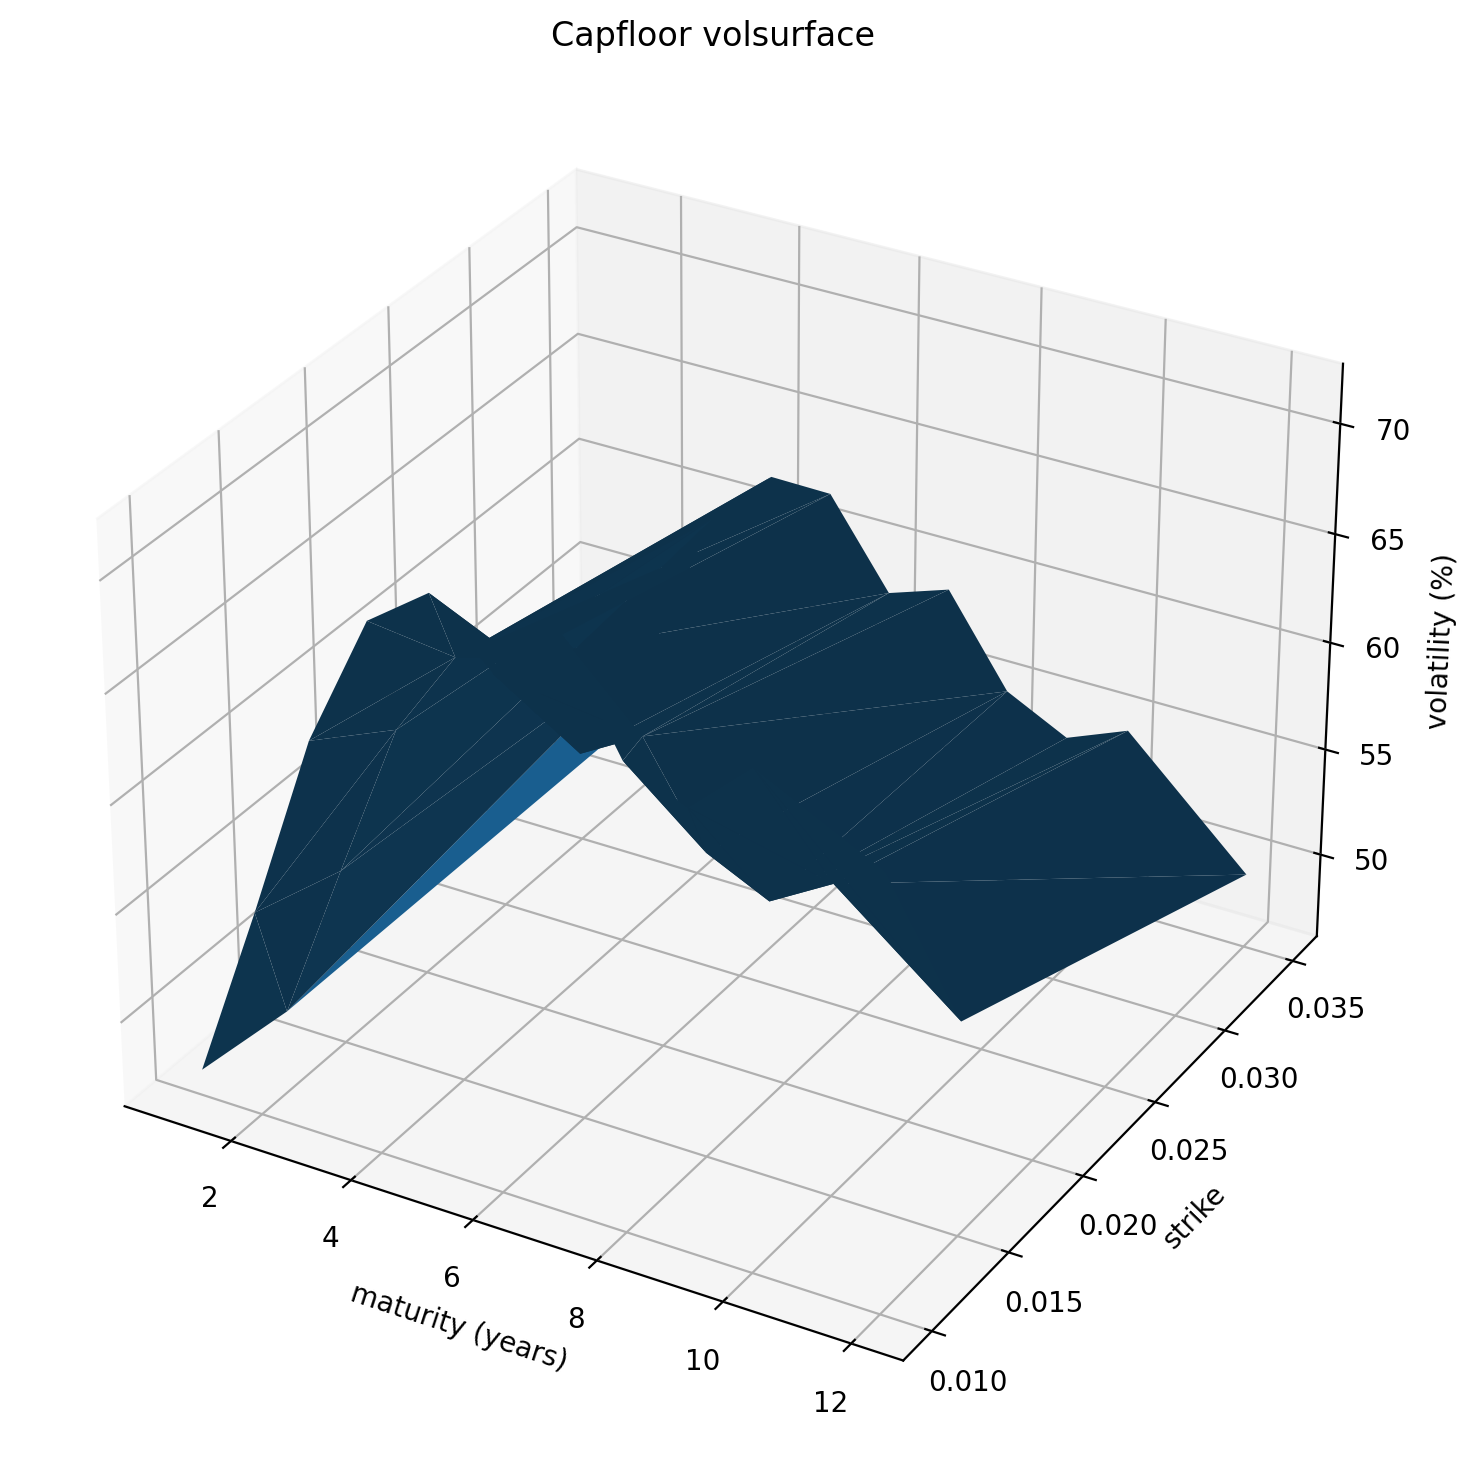

In [55]:
# transform the raw volsurface to a Quantlib's capfloor volsurface
# note the 'format' in which the volsurface is passed

calendar            = ql.TARGET()
bdc                 = ql.ModifiedFollowing
daycount            = ql.Actual365Fixed()
settlement_days     = 2
capfloor_volsurface = ql.CapFloorTermVolSurface(settlement_days, calendar, bdc, expiries, strikes,  
                                                capvols_df.applymap(lambda x: ql.QuoteHandle(ql.SimpleQuote(x))).values.tolist(),
                                                daycount)

    
# plot the volsurface in a surface plot
stacked_df = capvols_df.stack().reset_index().rename(columns = {'level_0':'maturity', 'level_1':'strike', 0:'volatility'})
fig = plt.figure(figsize =(14, 9))
ax  = plt.axes(projection ='3d')

ax.plot_trisurf(stacked_df['maturity'].astype('str').str.replace('Y','').astype(float), stacked_df['strike'], stacked_df['volatility']*100, 
                linewidth = 0.2, antialiased = True);
ax.set_title('Capfloor volsurface');
ax.set_xlabel('maturity (years)');
ax.set_ylabel('strike');
ax.set_zlabel('volatility (%)');

In [56]:
# obtain volatility for a particular strike (this can be fed in cap/floor pricing);
capfloor_volsurface.volatility(end_date, strike)

0.5355989912400306

## Strip caplet vols from caps
In this subsection we take the created capfloor volsurface and strip the caplet/floorlet volsurface from it.

In [57]:
# strip optionlet vols from capfloor volsurface
# note that to strip the optionlet surface, we need to define which model we are using (in this case it is shifted lognormal)
optionlet_volsruface        = ql.OptionletStripper1(capfloor_volsurface, ibor_index, 
                                                    type = ql.ShiftedLognormal, 
                                                    displacement = shift, 
                                                    discount = discount_curve)

# finally, we need to transform: ql.OptionLetStripper1 ->ql.StrippedOptionletAdapter -> ql.OptionletVolatilityStructureHandle
# the ql.OptionletVolatilityStructureHandle is the pricing-friendly representation of the caplet volsurface
optionlet_volsurface_handle = ql.OptionletVolatilityStructureHandle(ql.StrippedOptionletAdapter(optionlet_volsruface))

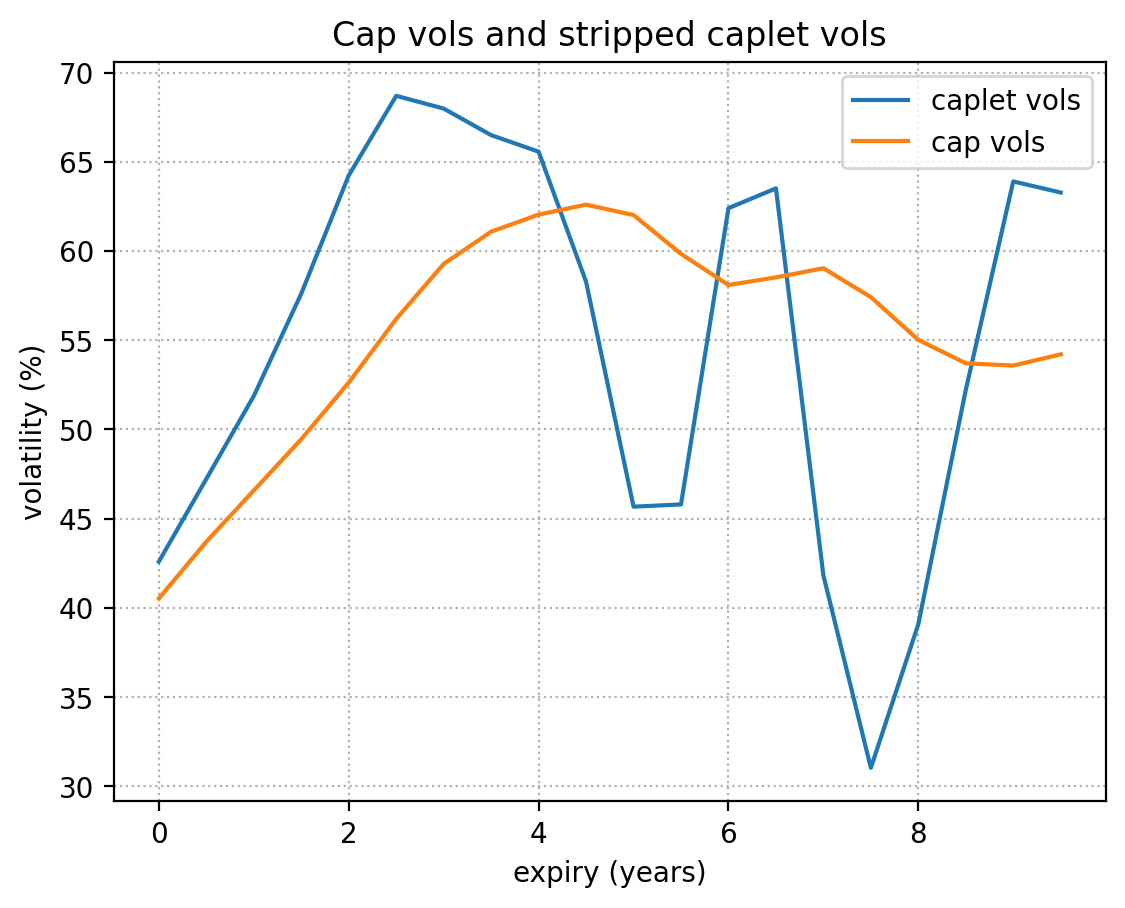

In [58]:
# plot caplet vols and cap vols
tenors = np.arange(0,10,0.5)
strike = 0.035

# optionlet vols are for expiry, not for the final date
optionlets_vols     = [optionlet_volsurface_handle.volatility(expiry, strike)*100 for expiry in tenors]
capfloor_vols       = [capfloor_volsurface.volatility(tenor, strike)*100 for tenor in tenors]

fig, ax = plt.subplots()
ax.plot(tenors, optionlets_vols, label = 'caplet vols');
ax.plot(tenors, capfloor_vols, label = 'cap vols');
ax.set_title('Cap vols and stripped caplet vols');
ax.set_xlabel('expiry (years)');
ax.set_ylabel('volatility (%)');
ax.legend();
ax.grid(linestyle = ':');

## Compare cap pricing via i) orig cap vols and ii) stripped caplet vols
In this section, we compare pricing of cap via original volatility vs stripped caplet vols

In [59]:
strike = 0.035
cap    = ql.Cap(ibor_leg, [strike])
engine = ql.BlackCapFloorEngine(discount_curve, 
                                ql.QuoteHandle(ql.SimpleQuote(capfloor_volsurface.volatility(cap.maturityDate(), strike))), 
                                ql.SimpleDayCounter(),
                                shift)
cap.setPricingEngine(engine)
print('Cap pricing using a single cap vol. NPV=', cap.NPV())

engine = ql.BlackCapFloorEngine(discount_curve, optionlet_volsurface_handle, shift)
cap.setPricingEngine(engine)
print('Cap pricing using stripped caplet vols. NPV=', cap.NPV())

Cap pricing using a single cap vol. NPV= 193181.8146501185
Cap pricing using stripped caplet vols. NPV= 193208.6037415496


# Define and use optionlet volsurface explicitly
In this section we assume that we are given optionlet surface instead of capfloor volsurface.
Then we want to use this optionlet volsurface to price a cap.

**Note**: keep in mind that the dates for optionlets have slightly different meaning than the dates for the cap:
- date $T$ for an optionlet is its _expiry_ date. So $T=5$ for a caplet labels a caplet that _expires_ in $T$ years and covers a period $[5Y,5Y+\delta]$,
- date $T$ for a caplfoor is the _termination_ date of a cap, so $T=5$ for a cap that _terminates_ at $T=5$, so it covers a period $[0,5Y]$.  

This representation is also used used by `QuantLib`.

In [60]:
# optionlet volsurface (n expiries X k strikes)

volsurface = [[0.52, 0.47], 
              [0.61, 0.58], 
              [0.68, 0.71]]

strikes  = [0.01, 0.05]
expiries = [ql.Date(10, 8, 2016), ql.Date(10, 2, 2017), ql.Date(10, 2, 2028)]
# note that in the case of CAP volsurface we could use periods such as (1Y, 2Y, ..., 10Y). For optionlet volsurface only dates are allowed

volsurface = pd.DataFrame(volsurface, columns = strikes, index = expiries)#.applymap(lambda x: ql.QuoteHandle(ql.SimpleQuote(x)))
display('Display (expiry x strike) volsurface: ', volsurface)

# make every element x of the volsurface QuoteHandle(SimpleQuote(x)), transformed to a list of lists
volsurface = volsurface.applymap(lambda x: ql.QuoteHandle(ql.SimpleQuote(x))).values.tolist()

# define the ql volsurface as StrippedOptionlet surface; and then make it a handle that can be used in the pricing function
volsurface_ql = ql.StrippedOptionlet(settlement_days, calendar, bdc, ibor_index, expiries, strikes, volsurface, daycount, ql.ShiftedLognormal, shift)
volsurface_ql = ql.OptionletVolatilityStructureHandle(ql.StrippedOptionletAdapter(volsurface_ql))



'Display (expiry x strike) volsurface: '

,0.01,0.05
"August 10th, 2016",0.52,0.47
"February 10th, 2017",0.61,0.58
"February 10th, 2028",0.68,0.71


In [61]:
strike = 0.02
cap    = ql.Cap(ibor_leg, [strike])

# use the explicitly defined caplet vols in pricing
engine = ql.BlackCapFloorEngine(discount_curve, volsurface_ql, shift)

cap.setPricingEngine(engine)
print(cap.NPV())

260613.22337680496
